In [1]:
import os
import random
import gc

import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.cluster import KMeans

import cv2
from imutils import paths
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.sys.path.append('../src')
from helpers import resize_to_fit

In [3]:
letters_dir = '../data/letters'

In [4]:
LETTER_IMAGES_FOLDER = letters_dir

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 28, 28)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


In [5]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [6]:
# Split the training data into separate train and test sets
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [7]:
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 10
log_interval = 10

In [8]:
X_train_t = (torch.from_numpy(X_train).float().transpose(1,3)).transpose(2,3)
y_train_t = torch.from_numpy(y_train).long()

train_data = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=round(batch_size_train), shuffle=True)

In [9]:
X_test_t = (torch.from_numpy(X_test).float().transpose(1,3)).transpose(2,3)
y_test_t = torch.from_numpy(y_test).long()

test_data = torch.utils.data.TensorDataset(X_test_t, y_test_t)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

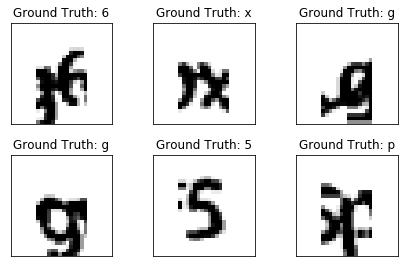

In [11]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(le.inverse_transform(example_targets)[i]))
    plt.xticks([])
    plt.yticks([])

In [12]:
class Net(nn.Module):
    def __init__(self, H, D):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, H)
        self.fc2 = nn.Linear(H, 32)
        self.dropout = nn.Dropout(D)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return F.log_softmax(x, dim=0)

In [13]:
net = Net(50, 0.5)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [14]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [15]:
def train(epoch, v=True):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if v:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')

In [16]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [17]:
n_epochs = 30
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 6.6388, Accuracy: 29/1200 (2%)

Train Epoch: 1 [0/3597 (0%)]	Loss: 4.610177
Train Epoch: 1 [1000/3597 (28%)]	Loss: 4.622381
Train Epoch: 1 [2000/3597 (56%)]	Loss: 4.578241
Train Epoch: 1 [3000/3597 (83%)]	Loss: 4.511089

Test set: Avg. loss: 6.2953, Accuracy: 435/1200 (36%)

Train Epoch: 2 [0/3597 (0%)]	Loss: 4.353375
Train Epoch: 2 [1000/3597 (28%)]	Loss: 4.328306
Train Epoch: 2 [2000/3597 (56%)]	Loss: 4.143792
Train Epoch: 2 [3000/3597 (83%)]	Loss: 4.052386

Test set: Avg. loss: 5.7679, Accuracy: 703/1200 (58%)

Train Epoch: 3 [0/3597 (0%)]	Loss: 4.199760
Train Epoch: 3 [1000/3597 (28%)]	Loss: 4.118123
Train Epoch: 3 [2000/3597 (56%)]	Loss: 4.068819
Train Epoch: 3 [3000/3597 (83%)]	Loss: 4.038464

Test set: Avg. loss: 5.6820, Accuracy: 746/1200 (62%)

Train Epoch: 4 [0/3597 (0%)]	Loss: 4.186470
Train Epoch: 4 [1000/3597 (28%)]	Loss: 3.974908
Train Epoch: 4 [2000/3597 (56%)]	Loss: 4.016304
Train Epoch: 4 [3000/3597 (83%)]	Loss: 4.058737

Test set: Avg. loss: 5.48

ValueError: x and y must be the same size

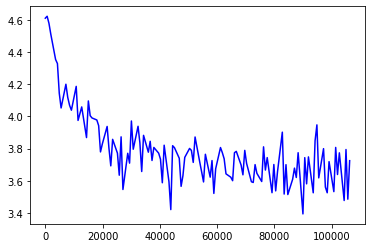

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

Net with H = 50, D = 0

Test set: Avg. loss: 6.6399, Accuracy: 29/1200 (2%)


Test set: Avg. loss: 4.8125, Accuracy: 848/1200 (70%)


Test set: Avg. loss: 4.5741, Accuracy: 934/1200 (77%)


Test set: Avg. loss: 4.4059, Accuracy: 1008/1200 (84%)


Test set: Avg. loss: 4.4106, Accuracy: 981/1200 (81%)


Test set: Avg. loss: 4.3373, Accuracy: 1020/1200 (85%)


Test set: Avg. loss: 4.3172, Accuracy: 1046/1200 (87%)


Test set: Avg. loss: 4.3161, Accuracy: 1040/1200 (86%)


Test set: Avg. loss: 4.3060, Accuracy: 1028/1200 (85%)


Test set: Avg. loss: 4.3573, Accuracy: 1010/1200 (84%)


Test set: Avg. loss: 4.2727, Accuracy: 1040/1200 (86%)


Test set: Avg. loss: 4.3036, Accuracy: 1050/1200 (87%)


Test set: Avg. loss: 4.2729, Accuracy: 1050/1200 (87%)


Test set: Avg. loss: 4.2724, Accuracy: 1055/1200 (87%)


Test set: Avg. loss: 4.2792, Accuracy: 1030/1200 (85%)


Test set: Avg. loss: 4.2559, Accuracy: 1053/1200 (87%)


Test set: Avg. loss: 4.2928, Accuracy: 1038/1200 (86%)


Test set: Avg

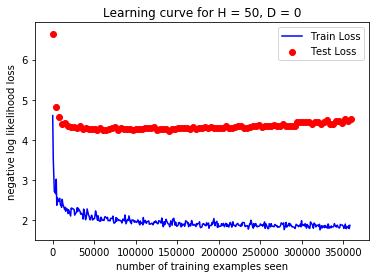

Net with H = 50, D = 0.3

Test set: Avg. loss: 6.6405, Accuracy: 34/1200 (2%)


Test set: Avg. loss: 5.6589, Accuracy: 690/1200 (57%)


Test set: Avg. loss: 5.1073, Accuracy: 837/1200 (69%)


Test set: Avg. loss: 4.8652, Accuracy: 950/1200 (79%)


Test set: Avg. loss: 4.6790, Accuracy: 951/1200 (79%)


Test set: Avg. loss: 4.5741, Accuracy: 990/1200 (82%)


Test set: Avg. loss: 4.5175, Accuracy: 1005/1200 (83%)


Test set: Avg. loss: 4.4506, Accuracy: 1015/1200 (84%)


Test set: Avg. loss: 4.4565, Accuracy: 1002/1200 (83%)


Test set: Avg. loss: 4.4694, Accuracy: 1031/1200 (85%)


Test set: Avg. loss: 4.4660, Accuracy: 1011/1200 (84%)


Test set: Avg. loss: 4.3510, Accuracy: 1038/1200 (86%)


Test set: Avg. loss: 4.3182, Accuracy: 1047/1200 (87%)


Test set: Avg. loss: 4.3086, Accuracy: 1042/1200 (86%)


Test set: Avg. loss: 4.2441, Accuracy: 1055/1200 (87%)


Test set: Avg. loss: 4.2809, Accuracy: 1046/1200 (87%)


Test set: Avg. loss: 4.2461, Accuracy: 1060/1200 (88%)


Test set: Avg

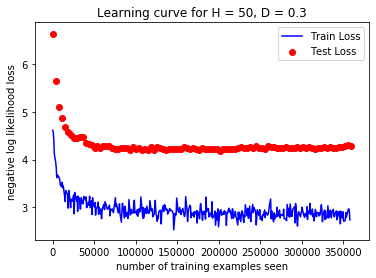

Net with H = 50, D = 0.5

Test set: Avg. loss: 6.6409, Accuracy: 26/1200 (2%)


Test set: Avg. loss: 6.4761, Accuracy: 321/1200 (26%)


Test set: Avg. loss: 5.9196, Accuracy: 776/1200 (64%)


Test set: Avg. loss: 5.4430, Accuracy: 874/1200 (72%)


Test set: Avg. loss: 5.3207, Accuracy: 941/1200 (78%)


Test set: Avg. loss: 5.2144, Accuracy: 950/1200 (79%)


Test set: Avg. loss: 4.9746, Accuracy: 964/1200 (80%)


Test set: Avg. loss: 4.8969, Accuracy: 996/1200 (83%)


Test set: Avg. loss: 4.8691, Accuracy: 986/1200 (82%)


Test set: Avg. loss: 4.7606, Accuracy: 982/1200 (81%)


Test set: Avg. loss: 4.6594, Accuracy: 981/1200 (81%)


Test set: Avg. loss: 4.7095, Accuracy: 995/1200 (82%)


Test set: Avg. loss: 4.6708, Accuracy: 998/1200 (83%)


Test set: Avg. loss: 4.6349, Accuracy: 1005/1200 (83%)


Test set: Avg. loss: 4.5731, Accuracy: 1019/1200 (84%)


Test set: Avg. loss: 4.6247, Accuracy: 998/1200 (83%)


Test set: Avg. loss: 4.6157, Accuracy: 1019/1200 (84%)


Test set: Avg. loss: 

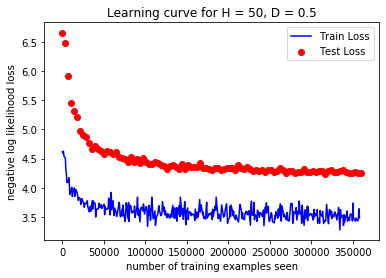

Net with H = 50, D = 0.7

Test set: Avg. loss: 6.6386, Accuracy: 44/1200 (3%)


Test set: Avg. loss: 6.5282, Accuracy: 410/1200 (34%)


Test set: Avg. loss: 6.3924, Accuracy: 601/1200 (50%)


Test set: Avg. loss: 6.2386, Accuracy: 757/1200 (63%)


Test set: Avg. loss: 6.0134, Accuracy: 758/1200 (63%)


Test set: Avg. loss: 5.9961, Accuracy: 820/1200 (68%)


Test set: Avg. loss: 5.8752, Accuracy: 842/1200 (70%)


Test set: Avg. loss: 5.9387, Accuracy: 797/1200 (66%)


Test set: Avg. loss: 5.8522, Accuracy: 825/1200 (68%)


Test set: Avg. loss: 5.8687, Accuracy: 855/1200 (71%)


Test set: Avg. loss: 5.7652, Accuracy: 855/1200 (71%)


Test set: Avg. loss: 5.7777, Accuracy: 894/1200 (74%)


Test set: Avg. loss: 5.9394, Accuracy: 876/1200 (73%)


Test set: Avg. loss: 5.7143, Accuracy: 888/1200 (74%)


Test set: Avg. loss: 5.7566, Accuracy: 911/1200 (75%)


Test set: Avg. loss: 5.4366, Accuracy: 919/1200 (76%)


Test set: Avg. loss: 5.5957, Accuracy: 923/1200 (76%)


Test set: Avg. loss: 5.6

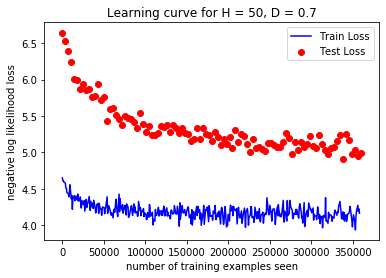

Net with H = 120, D = 0

Test set: Avg. loss: 6.6396, Accuracy: 39/1200 (3%)


Test set: Avg. loss: 4.7577, Accuracy: 916/1200 (76%)


Test set: Avg. loss: 4.5812, Accuracy: 989/1200 (82%)


Test set: Avg. loss: 4.4920, Accuracy: 1002/1200 (83%)


Test set: Avg. loss: 4.3991, Accuracy: 1053/1200 (87%)


Test set: Avg. loss: 4.4133, Accuracy: 1043/1200 (86%)


Test set: Avg. loss: 4.4189, Accuracy: 1045/1200 (87%)


Test set: Avg. loss: 4.3638, Accuracy: 1056/1200 (88%)


Test set: Avg. loss: 4.3509, Accuracy: 1065/1200 (88%)


Test set: Avg. loss: 4.3336, Accuracy: 1052/1200 (87%)


Test set: Avg. loss: 4.3385, Accuracy: 1059/1200 (88%)


Test set: Avg. loss: 4.3128, Accuracy: 1079/1200 (89%)


Test set: Avg. loss: 4.2833, Accuracy: 1082/1200 (90%)


Test set: Avg. loss: 4.3166, Accuracy: 1077/1200 (89%)


Test set: Avg. loss: 4.3075, Accuracy: 1066/1200 (88%)


Test set: Avg. loss: 4.2713, Accuracy: 1078/1200 (89%)


Test set: Avg. loss: 4.2878, Accuracy: 1077/1200 (89%)


Test set: A

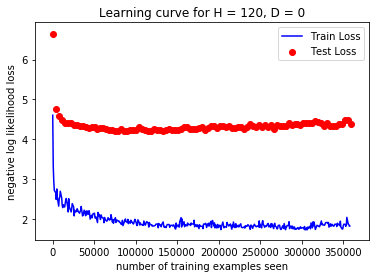

Net with H = 120, D = 0.3

Test set: Avg. loss: 6.6396, Accuracy: 29/1200 (2%)


Test set: Avg. loss: 5.0174, Accuracy: 914/1200 (76%)


Test set: Avg. loss: 4.7162, Accuracy: 1007/1200 (83%)


Test set: Avg. loss: 4.5703, Accuracy: 1033/1200 (86%)


Test set: Avg. loss: 4.5111, Accuracy: 1052/1200 (87%)


Test set: Avg. loss: 4.3450, Accuracy: 1065/1200 (88%)


Test set: Avg. loss: 4.3248, Accuracy: 1067/1200 (88%)


Test set: Avg. loss: 4.2790, Accuracy: 1076/1200 (89%)


Test set: Avg. loss: 4.2725, Accuracy: 1078/1200 (89%)


Test set: Avg. loss: 4.2979, Accuracy: 1075/1200 (89%)


Test set: Avg. loss: 4.2222, Accuracy: 1069/1200 (89%)


Test set: Avg. loss: 4.1856, Accuracy: 1090/1200 (90%)


Test set: Avg. loss: 4.1870, Accuracy: 1081/1200 (90%)


Test set: Avg. loss: 4.1804, Accuracy: 1075/1200 (89%)


Test set: Avg. loss: 4.1431, Accuracy: 1094/1200 (91%)


Test set: Avg. loss: 4.1334, Accuracy: 1096/1200 (91%)


Test set: Avg. loss: 4.1222, Accuracy: 1103/1200 (91%)


Test set

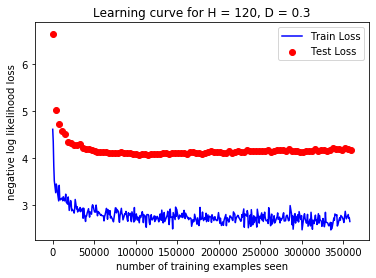

Net with H = 120, D = 0.5

Test set: Avg. loss: 6.6399, Accuracy: 26/1200 (2%)


Test set: Avg. loss: 6.4632, Accuracy: 465/1200 (38%)


Test set: Avg. loss: 5.8687, Accuracy: 620/1200 (51%)


Test set: Avg. loss: 5.7285, Accuracy: 663/1200 (55%)


Test set: Avg. loss: 5.7395, Accuracy: 743/1200 (61%)


Test set: Avg. loss: 5.5311, Accuracy: 768/1200 (64%)


Test set: Avg. loss: 5.5273, Accuracy: 799/1200 (66%)


Test set: Avg. loss: 5.4247, Accuracy: 815/1200 (67%)


Test set: Avg. loss: 5.4398, Accuracy: 797/1200 (66%)


Test set: Avg. loss: 5.3867, Accuracy: 852/1200 (71%)


Test set: Avg. loss: 5.3899, Accuracy: 833/1200 (69%)


Test set: Avg. loss: 5.1959, Accuracy: 856/1200 (71%)


Test set: Avg. loss: 5.2485, Accuracy: 821/1200 (68%)


Test set: Avg. loss: 5.2155, Accuracy: 857/1200 (71%)


Test set: Avg. loss: 5.1074, Accuracy: 878/1200 (73%)


Test set: Avg. loss: 5.1448, Accuracy: 883/1200 (73%)


Test set: Avg. loss: 5.0827, Accuracy: 876/1200 (73%)


Test set: Avg. loss: 5.

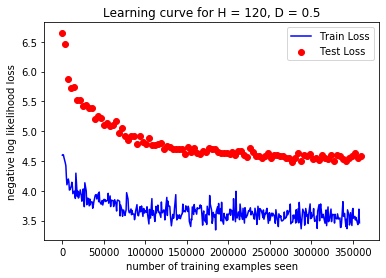

Net with H = 120, D = 0.7

Test set: Avg. loss: 6.6406, Accuracy: 32/1200 (2%)


Test set: Avg. loss: 6.6072, Accuracy: 295/1200 (24%)


Test set: Avg. loss: 6.3792, Accuracy: 520/1200 (43%)


Test set: Avg. loss: 6.3195, Accuracy: 708/1200 (59%)


Test set: Avg. loss: 6.1123, Accuracy: 771/1200 (64%)


Test set: Avg. loss: 6.1055, Accuracy: 755/1200 (62%)


Test set: Avg. loss: 6.0020, Accuracy: 774/1200 (64%)


Test set: Avg. loss: 6.0772, Accuracy: 756/1200 (63%)


Test set: Avg. loss: 5.9615, Accuracy: 809/1200 (67%)


Test set: Avg. loss: 5.9249, Accuracy: 821/1200 (68%)


Test set: Avg. loss: 5.8997, Accuracy: 821/1200 (68%)


Test set: Avg. loss: 5.8177, Accuracy: 801/1200 (66%)


Test set: Avg. loss: 5.9843, Accuracy: 790/1200 (65%)


Test set: Avg. loss: 5.7614, Accuracy: 828/1200 (69%)


Test set: Avg. loss: 5.7397, Accuracy: 819/1200 (68%)


Test set: Avg. loss: 5.8431, Accuracy: 836/1200 (69%)


Test set: Avg. loss: 5.7646, Accuracy: 838/1200 (69%)


Test set: Avg. loss: 5.

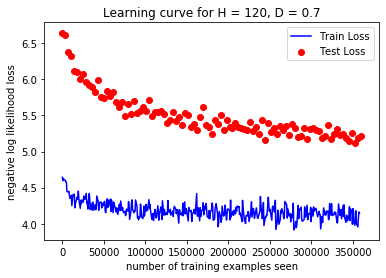

Net with H = 320, D = 0

Test set: Avg. loss: 6.6386, Accuracy: 56/1200 (4%)


Test set: Avg. loss: 4.7295, Accuracy: 952/1200 (79%)


Test set: Avg. loss: 4.5312, Accuracy: 1010/1200 (84%)


Test set: Avg. loss: 4.4804, Accuracy: 1024/1200 (85%)


Test set: Avg. loss: 4.4343, Accuracy: 1042/1200 (86%)


Test set: Avg. loss: 4.3806, Accuracy: 1054/1200 (87%)


Test set: Avg. loss: 4.3732, Accuracy: 1064/1200 (88%)


Test set: Avg. loss: 4.3286, Accuracy: 1071/1200 (89%)


Test set: Avg. loss: 4.3046, Accuracy: 1085/1200 (90%)


Test set: Avg. loss: 4.3692, Accuracy: 1059/1200 (88%)


Test set: Avg. loss: 4.2855, Accuracy: 1083/1200 (90%)


Test set: Avg. loss: 4.2447, Accuracy: 1083/1200 (90%)


Test set: Avg. loss: 4.2554, Accuracy: 1083/1200 (90%)


Test set: Avg. loss: 4.2806, Accuracy: 1079/1200 (89%)


Test set: Avg. loss: 4.1888, Accuracy: 1104/1200 (92%)


Test set: Avg. loss: 4.2304, Accuracy: 1086/1200 (90%)


Test set: Avg. loss: 4.2277, Accuracy: 1089/1200 (90%)


Test set: 

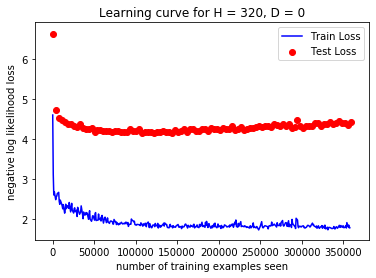

Net with H = 320, D = 0.3

Test set: Avg. loss: 6.6422, Accuracy: 20/1200 (1%)


Test set: Avg. loss: 5.1104, Accuracy: 853/1200 (71%)


Test set: Avg. loss: 4.7482, Accuracy: 984/1200 (82%)


Test set: Avg. loss: 4.6247, Accuracy: 1027/1200 (85%)


Test set: Avg. loss: 4.5385, Accuracy: 1021/1200 (85%)


Test set: Avg. loss: 4.4866, Accuracy: 1027/1200 (85%)


Test set: Avg. loss: 4.3467, Accuracy: 1068/1200 (89%)


Test set: Avg. loss: 4.3894, Accuracy: 1068/1200 (89%)


Test set: Avg. loss: 4.3590, Accuracy: 1058/1200 (88%)


Test set: Avg. loss: 4.3149, Accuracy: 1071/1200 (89%)


Test set: Avg. loss: 4.2641, Accuracy: 1078/1200 (89%)


Test set: Avg. loss: 4.2763, Accuracy: 1073/1200 (89%)


Test set: Avg. loss: 4.2575, Accuracy: 1076/1200 (89%)


Test set: Avg. loss: 4.2385, Accuracy: 1078/1200 (89%)


Test set: Avg. loss: 4.1948, Accuracy: 1089/1200 (90%)


Test set: Avg. loss: 4.2256, Accuracy: 1077/1200 (89%)


Test set: Avg. loss: 4.1970, Accuracy: 1089/1200 (90%)


Test set:

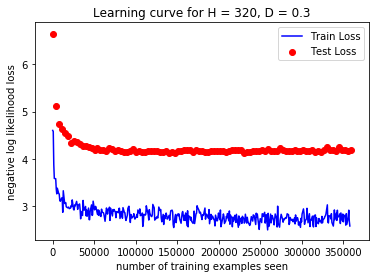

Net with H = 320, D = 0.5

Test set: Avg. loss: 6.6387, Accuracy: 26/1200 (2%)


Test set: Avg. loss: 6.5913, Accuracy: 381/1200 (31%)


Test set: Avg. loss: 5.4761, Accuracy: 865/1200 (72%)


Test set: Avg. loss: 5.2530, Accuracy: 957/1200 (79%)


Test set: Avg. loss: 5.0339, Accuracy: 991/1200 (82%)


Test set: Avg. loss: 5.1033, Accuracy: 1009/1200 (84%)


Test set: Avg. loss: 4.8434, Accuracy: 1017/1200 (84%)


Test set: Avg. loss: 4.7424, Accuracy: 1048/1200 (87%)


Test set: Avg. loss: 4.7948, Accuracy: 1045/1200 (87%)


Test set: Avg. loss: 4.8517, Accuracy: 1040/1200 (86%)


Test set: Avg. loss: 4.6190, Accuracy: 1050/1200 (87%)


Test set: Avg. loss: 4.7022, Accuracy: 1045/1200 (87%)


Test set: Avg. loss: 4.7568, Accuracy: 1049/1200 (87%)


Test set: Avg. loss: 4.5416, Accuracy: 1066/1200 (88%)


Test set: Avg. loss: 4.6074, Accuracy: 1045/1200 (87%)


Test set: Avg. loss: 4.5435, Accuracy: 1057/1200 (88%)


Test set: Avg. loss: 4.5042, Accuracy: 1059/1200 (88%)


Test set: A

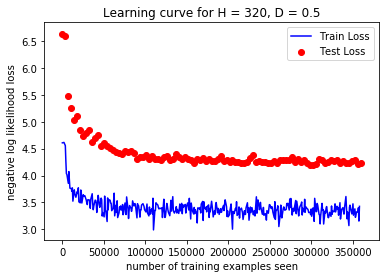

Net with H = 320, D = 0.7

Test set: Avg. loss: 6.6399, Accuracy: 35/1200 (2%)


Test set: Avg. loss: 6.5992, Accuracy: 400/1200 (33%)


Test set: Avg. loss: 6.2058, Accuracy: 744/1200 (62%)


Test set: Avg. loss: 6.1592, Accuracy: 726/1200 (60%)


Test set: Avg. loss: 5.9339, Accuracy: 825/1200 (68%)


Test set: Avg. loss: 5.8135, Accuracy: 858/1200 (71%)


Test set: Avg. loss: 5.9753, Accuracy: 823/1200 (68%)


Test set: Avg. loss: 5.8179, Accuracy: 879/1200 (73%)


Test set: Avg. loss: 5.7570, Accuracy: 894/1200 (74%)


Test set: Avg. loss: 5.6929, Accuracy: 941/1200 (78%)


Test set: Avg. loss: 5.7115, Accuracy: 940/1200 (78%)


Test set: Avg. loss: 5.6267, Accuracy: 940/1200 (78%)


Test set: Avg. loss: 5.6487, Accuracy: 943/1200 (78%)


Test set: Avg. loss: 5.5823, Accuracy: 927/1200 (77%)


Test set: Avg. loss: 5.5341, Accuracy: 926/1200 (77%)


Test set: Avg. loss: 5.5156, Accuracy: 941/1200 (78%)


Test set: Avg. loss: 5.4249, Accuracy: 970/1200 (80%)


Test set: Avg. loss: 5.

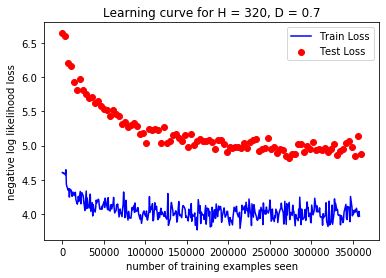

In [19]:
n_epochs = 100

for H in [50, 120, 320]:
    for D in [0, 0.3, 0.5, 0.7]:
        net = Net(H, D)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
        
        train_losses = []
        train_counter = []
        test_losses = []
        test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
        
        print("Net with H = {}, D = {}".format(H, D))
        
        test()
        for epoch in range(1, n_epochs + 1):
            train(epoch, False)
            test()
            
        fig = plt.figure()
        plt.plot(train_counter, train_losses, color='blue')
        plt.scatter(test_counter, test_losses, color='red')
        plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
        plt.xlabel('number of training examples seen')
        plt.ylabel('negative log likelihood loss')
        plt.title('Learning curve for H = {}, D = {}'.format(H, D))
        plt.show()   